In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
customer_indicators = pd.read_csv('datasets/customer_indicators.csv', index_col=0)

# Clustering

### Pre-processing

In [3]:
rfm_log = customer_indicators[['RMonetary']].apply(np.log10, axis=1).round(3)
rfm_log['Delta'] = customer_indicators[['Delta']].apply(np.log10, axis=1).round(3)
rfm_log['Recency'] = customer_indicators[['Recency']]#.apply(np.log10, axis=1).round(3)

#rfm_log = rfm_log[rfm_log['Delta'] > 0]

rfm_k = rfm_log[['Delta', 'Recency', 'RMonetary']]

scaler = StandardScaler()
scaled = scaler.fit_transform(rfm_k.values)

## K-means

In [4]:
sse = []
silhouette = []
kmax = 7
for k in range(2, kmax):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(scaled)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(scaled, kmeans.labels_))

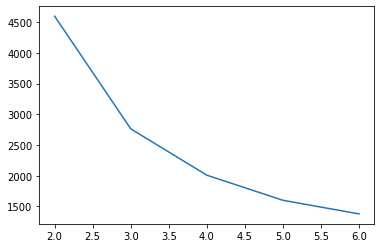

In [5]:
# Elbow curve.
ax = plt.plot(range(2, kmax), sse)
plt.show()

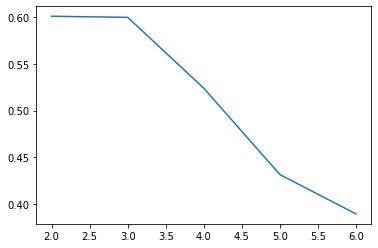

In [6]:
# Silhouette score.
ax = plt.plot(range(2, kmax), silhouette)
plt.show()

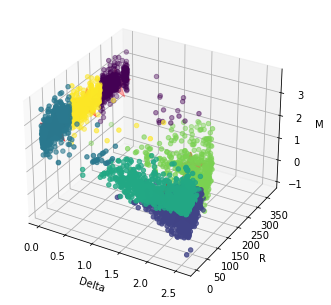

In [7]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_x = centers[:,0]
centroids_y = centers[:,1]
centroids_z = centers[:,2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rfm_log['Delta'], rfm_log['Recency'], rfm_log['RMonetary'], c=kmeans.labels_)
ax.scatter(centroids_x,centroids_y,centroids_z,s=1000, marker='*', c='r')
ax.set_xlabel('Delta')
ax.set_ylabel('R')
ax.set_zlabel('M')
plt.show()

### Post-processing

In [8]:
# create column containing cluster label
rfm_log['Behavior'] = kmeans.labels_
rfm_log.head()

,RMonetary,Delta,Recency,Behavior
0,1.071,2.563,2,3
1,0.706,2.452,75,1
2,3.164,0.000,19,2
3,2.469,0.000,310,0
4,0.725,2.417,36,1


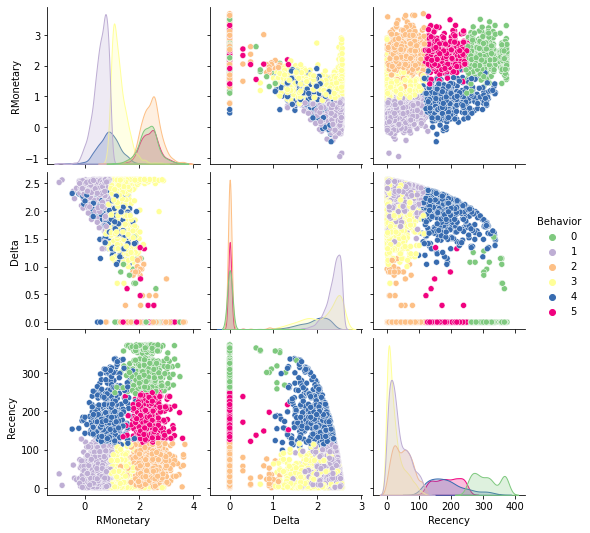

In [9]:
sns.pairplot(data = rfm_log, hue = "Behavior", palette = "Accent")
plt.show()

In [10]:
clusters = list()
for i in range(0,6):
    clusters.append(rfm_log[rfm_log['Behavior'] == i])

In [11]:
for i in range(0,len(clusters)):
    print(clusters[i].describe())

        RMonetary       Delta     Recency  Behavior
count  441.000000  441.000000  441.000000     441.0
mean     2.335673    0.037821  311.047619       0.0
std      0.355200    0.200608   39.830550       0.0
min      1.106000    0.000000  247.000000       0.0
25%      2.125000    0.000000  276.000000       0.0
50%      2.348000    0.000000  308.000000       0.0
75%      2.537000    0.000000  355.000000       0.0
max      3.506000    1.531000  374.000000       0.0
         RMonetary        Delta      Recency  Behavior
count  1257.000000  1257.000000  1257.000000    1257.0
mean      0.575727     2.366231    37.663484       1.0
std       0.262794     0.177887    29.854513       0.0
min      -0.954000     1.322000     1.000000       1.0
25%       0.420000     2.283000    14.000000       1.0
50%       0.620000     2.412000    29.000000       1.0
75%       0.776000     2.498000    59.000000       1.0
max       1.022000     2.571000   128.000000       1.0
        RMonetary       Delta     Rec

## DBSCAN

In [12]:
dist = pdist(scaled, 'euclidean')
dist = squareform(dist)

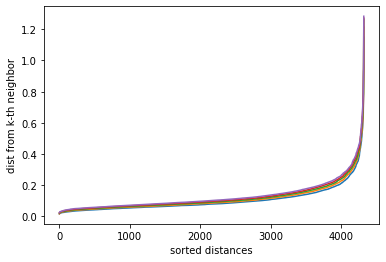

In [13]:
plt.ylabel('dist from k-th neighbor')
plt.xlabel('sorted distances')
plt.tick_params(axis='both')
for k in range(5, 10):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))

In [14]:
# Random parameters selection
density = DBSCAN(eps=0.2, min_samples=5).fit(scaled)
labels = density.labels_
labels

array([0, 0, 1, ..., 0, 0, 0])

In [15]:
dbscan_df = rfm_log.copy()
del dbscan_df['Behavior']
dbscan_df["label"] = labels

/usr/local/Cellar/python@3.8/3.8.6_2/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/Cellar/python@3.8/3.8.6_2/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


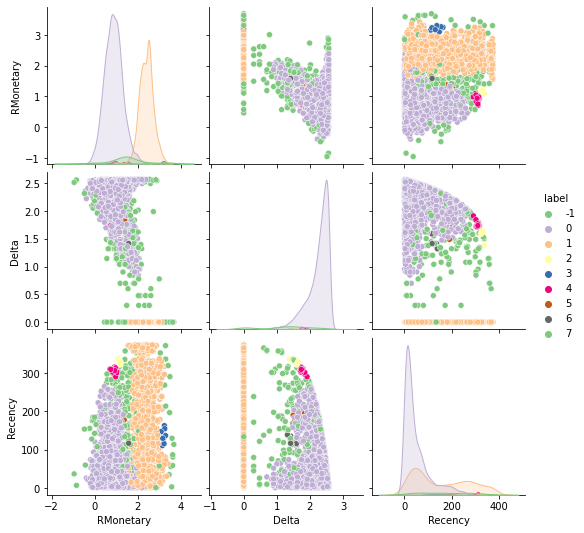

In [16]:
sns.pairplot(data = dbscan_df, hue = "label", palette = "Accent")
plt.show()

## Grid search

In [17]:
eps_to_test = [round(eps,1) for eps in np.arange(0.1, 2, 0.1)]
min_samples_to_test = range(5, 50, 5)

In [18]:
def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting
    dbscan_model_ = DBSCAN(eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean Noise Point Distance metric
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of found Clusters metric
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    
    # Log
    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

In [19]:
# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test), len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test), len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

In [20]:
iter_ = 0

print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
print("-"*65)

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        # Computing metrics
        noise_metric, cluster_metric = get_metrics(eps, min_samples, scaled, iter_)
        
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

ITER| INFO                                        |  DIST    CLUS
-----------------------------------------------------------------
  1 | Tested with eps = 0.1 and min_samples =   5 | 0.171   24
  2 | Tested with eps = 0.1 and min_samples =  10 | 0.136   21
  3 | Tested with eps = 0.1 and min_samples =  15 | 0.115   11
  4 | Tested with eps = 0.1 and min_samples =  20 | 0.104    6
  5 | Tested with eps = 0.1 and min_samples =  25 | 0.098    2
  6 | Tested with eps = 0.1 and min_samples =  30 | 0.095    4
  7 | Tested with eps = 0.1 and min_samples =  35 | 0.091    4
  8 | Tested with eps = 0.1 and min_samples =  40 | 0.087    1
  9 | Tested with eps = 0.1 and min_samples =  45 | 0.086    1
 10 | Tested with eps = 0.2 and min_samples =   5 | 0.311    8
 11 | Tested with eps = 0.2 and min_samples =  10 | 0.246    4
 12 | Tested with eps = 0.2 and min_samples =  15 | 0.212    4
 13 | Tested with eps = 0.2 and min_samples =  20 | 0.188    2
 14 | Tested with eps = 0.2 and min_samples =  25

129 | Tested with eps = 1.5 and min_samples =  15 |  None    1
130 | Tested with eps = 1.5 and min_samples =  20 |  None    1
131 | Tested with eps = 1.5 and min_samples =  25 |  None    1
132 | Tested with eps = 1.5 and min_samples =  30 |  None    1
133 | Tested with eps = 1.5 and min_samples =  35 |  None    1
134 | Tested with eps = 1.5 and min_samples =  40 |  None    1
135 | Tested with eps = 1.5 and min_samples =  45 |  None    1
136 | Tested with eps = 1.6 and min_samples =   5 |  None    1
137 | Tested with eps = 1.6 and min_samples =  10 |  None    1
138 | Tested with eps = 1.6 and min_samples =  15 |  None    1
139 | Tested with eps = 1.6 and min_samples =  20 |  None    1
140 | Tested with eps = 1.6 and min_samples =  25 |  None    1
141 | Tested with eps = 1.6 and min_samples =  30 |  None    1
142 | Tested with eps = 1.6 and min_samples =  35 |  None    1
143 | Tested with eps = 1.6 and min_samples =  40 |  None    1
144 | Tested with eps = 1.6 and min_samples =  45 |  No

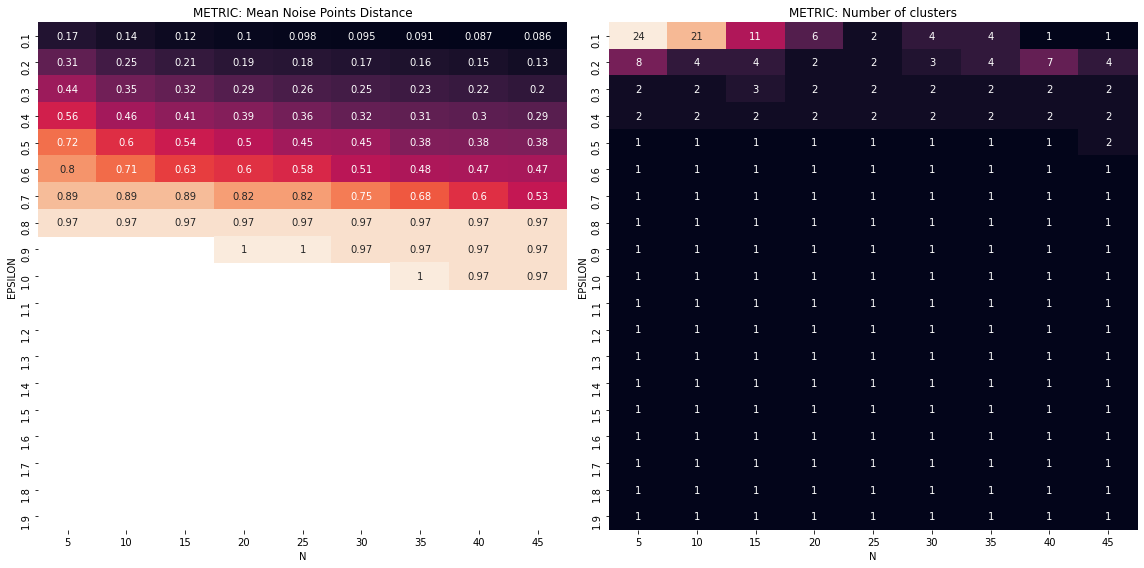

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")

ax1.set_xlabel("N"); ax2.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")

plt.tight_layout(); plt.show()

In [22]:
# Best parameters
density = DBSCAN(eps=0.4, min_samples=5).fit(scaled)
labels = density.labels_
print(metrics.silhouette_score(scaled, labels))

results = np.unique(labels, return_counts=True)
print(f"Clusters labels: {results[0]}")
print(f"Elements per cluster: {results[1]}")

0.502074955044931
Clusters labels: [-1  0  1]
Elements per cluster: [  21 2745 1556]


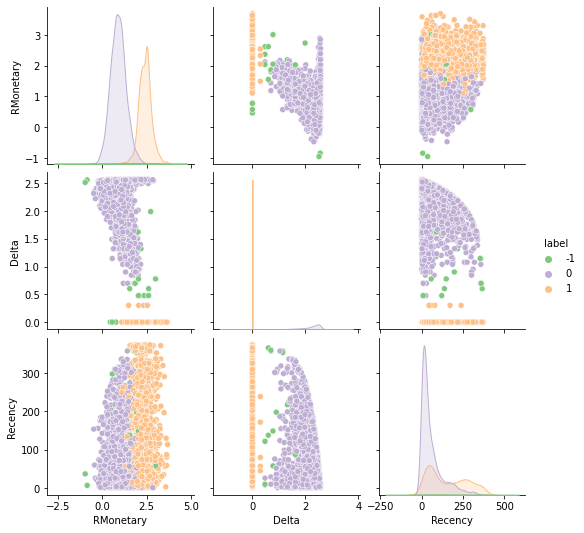

In [23]:
dbscan_df["label"] = labels
sns.pairplot(data=dbscan_df, hue="label", palette="Accent")
plt.show()

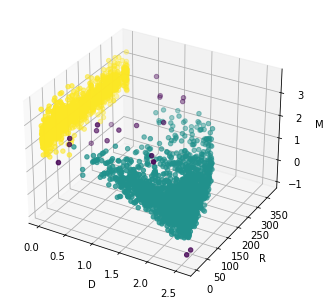

In [24]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rfm_log['Delta'], rfm_log['Recency'], rfm_log['RMonetary'], c=density.labels_)
ax.set_xlabel('D')
ax.set_ylabel('R')
ax.set_zlabel('M')
plt.show()

# Hierarchical

In [25]:
rfm_log = customer_indicators[['RMonetary']].apply(np.log10, axis=1).round(3)
rfm_log['Delta'] = customer_indicators[['Delta']].apply(np.log10, axis=1).round(3)
rfm_log['Recency'] = customer_indicators[['Recency']]#.apply(np.log10, axis=1).round(3)

rfm_k = rfm_log[['Delta', 'Recency', 'RMonetary']]
scaler = StandardScaler()
scaled = scaler.fit_transform(rfm_k.values)

data_scaled = pd.DataFrame(scaled, columns=rfm_log.columns)

0.2878296999937089


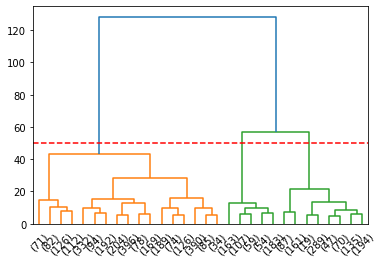

In [26]:
data_dist = pdist(scaled, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=50, color='r', linestyle='--')
clusters = fcluster(data_link, 0.50,  criterion='distance')
print(metrics.silhouette_score(data_scaled, clusters))

0.17844487801533715


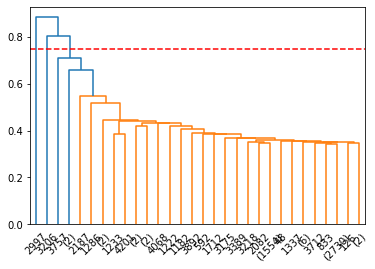

In [27]:
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=0.75, color='r', linestyle='--')
clusters = fcluster(data_link, 0.75,  criterion='distance')
print(metrics.silhouette_score(data_scaled, clusters))

0.3352158757198226


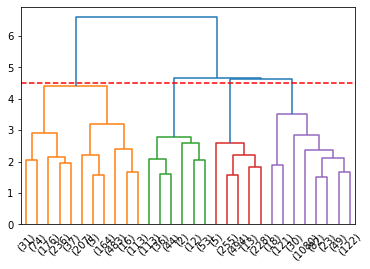

In [28]:
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=4.5, color='r', linestyle='--')
clusters = fcluster(data_link, 4.5,  criterion='distance')
print(metrics.silhouette_score(data_scaled, clusters))

0.4820712048072182


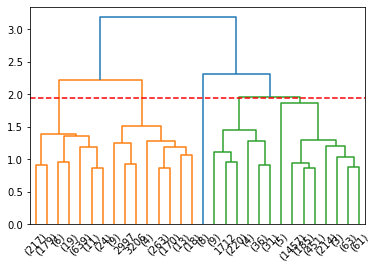

In [29]:
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=1.95, color='r', linestyle='--')
clusters = fcluster(data_link, 1.95,  criterion='distance')
print(metrics.silhouette_score(data_scaled, clusters))

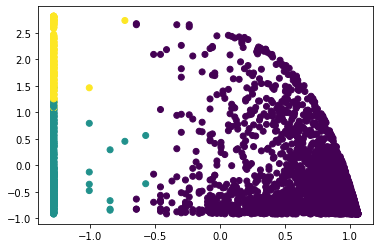

In [30]:
agg_ward = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
agg_ward.fit_predict(scaled)
plt.scatter(data_scaled['RMonetary'], data_scaled['Delta'], c=agg_ward.labels_) 

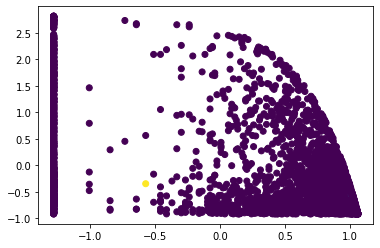

In [31]:
agg_single = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')  
agg_single.fit_predict(scaled)
plt.scatter(data_scaled['RMonetary'], data_scaled['Delta'], c=agg_single.labels_) 

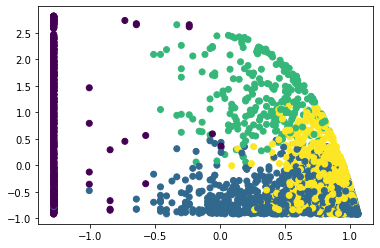

In [32]:
agg_comp = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
agg_comp.fit_predict(scaled)
plt.scatter(data_scaled['RMonetary'], data_scaled['Delta'], c=agg_comp.labels_) 

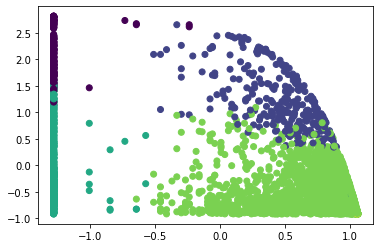

In [33]:
agg_avg = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='average')  
agg_avg.fit_predict(scaled)
plt.scatter(data_scaled['RMonetary'], data_scaled['Delta'], c=agg_avg.labels_) 

## Comparisons

In [34]:
labels_kmeans = kmeans.labels_
labels_comp = agg_comp.labels_
labels_avg = agg_avg.labels_
labels_ward = agg_ward.labels_
labels_single = agg_single.labels_

kmean_sil = metrics.silhouette_score(data_scaled, labels_kmeans)
ward_sil = metrics.silhouette_score(data_scaled, labels_ward) 
avg_sil = metrics.silhouette_score(data_scaled,labels_avg)  
comp_sil = metrics.silhouette_score(data_scaled, labels_comp)
single_sil = metrics.silhouette_score(data_scaled, labels_single)

print(kmean_sil)
print(ward_sil)
print(avg_sil)
print(comp_sil)
print(single_sil)

0.38934441515975593
0.5830440476494503
0.43121753715844485
0.3352158757198226
-0.10933764663803848


# Extra: X-Means

In [35]:
from pyclustering.samples.definitions import SIMPLE_SAMPLES, FCPS_SAMPLES;

from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer;

from pyclustering.cluster import cluster_visualizer;
from pyclustering.cluster.xmeans import xmeans, splitting_type;

In [36]:
# initial centers - optional parameter, if it is None, then random centers will be used by the algorithm.
# avoid random initial centers and initialize them using K-Means++ method

initial_centers = kmeans_plusplus_initializer(scaled, 2).initialize();
xmeans_instance = xmeans(scaled, initial_centers, criterion=splitting_type.BAYESIAN_INFORMATION_CRITERION, ccore=True);

### Bayesian Information Criterion

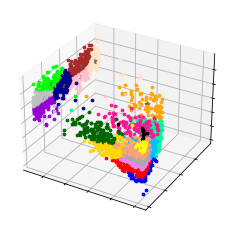

In [37]:
initial_centers = kmeans_plusplus_initializer(scaled, 2).initialize();
xmeans_instance = xmeans(scaled, initial_centers, criterion=splitting_type.BAYESIAN_INFORMATION_CRITERION, ccore=True);

# run cluster analysis
xmeans_instance.process();

# obtain results of clustering
clusters = xmeans_instance.get_clusters();
centers = xmeans_instance.get_centers()

# display allocated clusters
visualizer = cluster_visualizer();
visualizer.append_clusters(clusters, scaled);
visualizer.append_cluster(centers, None, marker = '*');
visualizer.show();

### MINIMUM_NOISELESS_DESCRIPTION_LENGTH

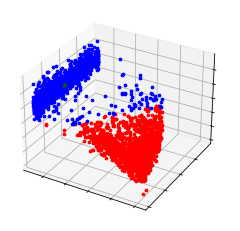

In [38]:
initial_centers = kmeans_plusplus_initializer(scaled, 2).initialize();
xmeans_instance = xmeans(scaled, initial_centers, criterion=splitting_type.MINIMUM_NOISELESS_DESCRIPTION_LENGTH, ccore=True);
# run cluster analysis
xmeans_instance.process();

# obtain results of clustering
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
# display allocated clusters
visualizer = cluster_visualizer();
visualizer.append_clusters(clusters, scaled);
visualizer.append_cluster(centers, None, marker = '*');
visualizer.show();

# SOM-SC

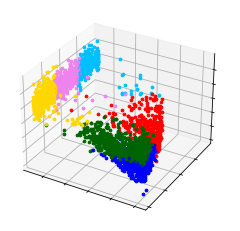

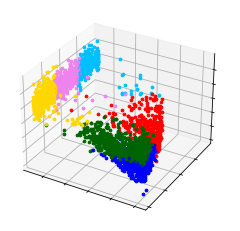

In [39]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.somsc import somsc
from pyclustering.samples.definitions import FCPS_SAMPLES

# Create instance of SOM-SC algorithm to allocated six clusters
somsc_instance = somsc(scaled, 6)
# Run cluster analysis and obtain results
somsc_instance.process()
clusters = somsc_instance.get_clusters()
# Visualize clustering results.
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, scaled)
visualizer.show()